# Dataset 3: Kaggle 190K+ Spam/Ham Email Dataset (Baseline vs Hyperparameter Optimization)

## Objective
The goal of this experiment is to evaluate spam detection performance on a large-scale email dataset using a TF-IDF + Logistic Regression pipeline. We compare a baseline model against a hyperparameter-optimized model. Because the dataset is large, hyperparameter tuning is performed on a stratified subset to control runtime, while final evaluation is performed on the full test set.

**Source:** Kaggle — “190K+ Spam | Ham Email Dataset for Classification”
https://www.kaggle.com/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification

## Environment Setup
This section imports the required Python libraries for data handling, model training, evaluation, and visualization.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Dataset Loading and Preprocessing
The dataset is provided as a CSV file containing email text and a spam/ham label. We apply minimal preprocessing:
- remove missing rows
- normalize label format
No heavy text cleaning is used because TF-IDF handles tokenization internally.

In [2]:
FILE_PATH = "/content/spam_Emails_data.csv"

# Load with a safe encoding (many email datasets are not UTF-8)
df3 = pd.read_csv(FILE_PATH, encoding="latin-1")

# Normalize column names
df3 = df3.rename(columns=lambda x: str(x).lower().strip())

print("Columns:", list(df3.columns))
df3.head()

Columns: ['label', 'text']


,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [3]:
# Auto-detect common column names
possible_text_cols  = ["text", "email", "message", "body", "content"]
possible_label_cols = ["label", "spam", "class", "category", "type"]

TEXT_COL = next((c for c in possible_text_cols if c in df3.columns), None)
LABEL_COL = next((c for c in possible_label_cols if c in df3.columns), None)

# If auto-detection fails, stop with a helpful message
if TEXT_COL is None or LABEL_COL is None:
    raise ValueError(
        f"Could not auto-detect TEXT_COL/LABEL_COL. Columns found: {list(df3.columns)}\n"
        "Set TEXT_COL and LABEL_COL manually to match your file."
    )

print("Using TEXT_COL =", TEXT_COL)
print("Using LABEL_COL =", LABEL_COL)

df3 = df3[[TEXT_COL, LABEL_COL]].dropna()

# Normalize label values to 0/1
df3[LABEL_COL] = df3[LABEL_COL].astype(str).str.lower().str.strip()

# Common mappings
df3[LABEL_COL] = df3[LABEL_COL].replace({
    "ham": "0", "not spam": "0", "not_spam": "0", "non-spam": "0", "nonspam": "0",
    "spam": "1"
})

# Convert to numeric if possible
df3[LABEL_COL] = pd.to_numeric(df3[LABEL_COL], errors="coerce")
df3 = df3.dropna(subset=[LABEL_COL])

df3[LABEL_COL] = df3[LABEL_COL].astype(int)

df3.head(), df3[LABEL_COL].value_counts(), df3.shape

Using TEXT_COL = text
Using LABEL_COL = label


(                                                text  label
 0  viiiiiiagraaaa\nonly for the ones that want to...      1
 1  got ice thought look az original message ice o...      0
 2  yo ur wom an ne eds an escapenumber in ch ma n...      1
 3  start increasing your odds of success & live s...      1
 4  author jra date escapenumber escapenumber esca...      0,
 label
 0    16837
 1    15035
 Name: count, dtype: int64,
 (31872, 2))

## Train-Test Split
The dataset is split into training and testing sets using an 80/20 ratio with stratification to preserve the class distribution.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df3[TEXT_COL],
    df3[LABEL_COL],
    test_size=0.2,
    random_state=42,
    stratify=df3[LABEL_COL]
)

## Baseline Model
A TF-IDF vectorizer combined with Logistic Regression is used as the baseline model. This is the same modeling approach used for Datasets 1 and 2, enabling consistent comparison across datasets.

In [5]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline.fit(X_train, y_train)
pred_base_3 = baseline.predict(X_test)

print("Dataset 3 Baseline accuracy:", accuracy_score(y_test, pred_base_3))
print(classification_report(y_test, pred_base_3))
print(confusion_matrix(y_test, pred_base_3))

Dataset 3 Baseline accuracy: 0.9697254901960785
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3368
           1       0.96      0.97      0.97      3007

    accuracy                           0.97      6375
   macro avg       0.97      0.97      0.97      6375
weighted avg       0.97      0.97      0.97      6375

[[3254  114]
 [  79 2928]]


## Hyperparameter Optimization (Subset Tuning)
Because Dataset 3 is very large, hyperparameter optimization is performed on a **stratified subset** to reduce computational cost. The best model is then evaluated on the full test set to ensure fair comparison.

In [6]:
SUBSET_SIZE = 30000  # safe size for Colab

df3_sample, _ = train_test_split(
    df3,
    train_size=SUBSET_SIZE,
    random_state=42,
    stratify=df3[LABEL_COL]
)

print("Subset shape:", df3_sample.shape)
print("Subset label proportion:\n", df3_sample[LABEL_COL].value_counts(normalize=True))
print("Full label proportion:\n", df3[LABEL_COL].value_counts(normalize=True))

Subset shape: (30000, 2)
Subset label proportion:
 label
0    0.528267
1    0.471733
Name: proportion, dtype: float64
Full label proportion:
 label
0    0.528269
1    0.471731
Name: proportion, dtype: float64


In [7]:
param_dist = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.8, 0.9, 1.0],
    "clf__C": [0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

X_train_s, _, y_train_s, _ = train_test_split(
    df3_sample[TEXT_COL],
    df3_sample[LABEL_COL],
    test_size=0.2,
    random_state=42,
    stratify=df3_sample[LABEL_COL]
)

search3 = RandomizedSearchCV(
    baseline,
    param_distributions=param_dist,
    n_iter=8,           # reduced for speed on large data
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search3.fit(X_train_s, y_train_s)

print("Dataset 3 Best parameters:", search3.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Dataset 3 Best parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_df': 0.8, 'clf__class_weight': None, 'clf__C': 10}


In [8]:
best_model_3 = search3.best_estimator_
pred_tuned_3 = best_model_3.predict(X_test)

print("Dataset 3 Tuned accuracy:", accuracy_score(y_test, pred_tuned_3))
print(classification_report(y_test, pred_tuned_3))
print(confusion_matrix(y_test, pred_tuned_3))

Dataset 3 Tuned accuracy: 0.9896470588235294
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3368
           1       0.99      0.99      0.99      3007

    accuracy                           0.99      6375
   macro avg       0.99      0.99      0.99      6375
weighted avg       0.99      0.99      0.99      6375

[[3330   38]
 [  28 2979]]


## Model Comparison
Baseline and tuned models are compared using accuracy and spam recall to visualize performance differences.

In [9]:
# Extract spam recall (label=1) from classification reports
base_report = classification_report(y_test, pred_base_3, output_dict=True)
tuned_report = classification_report(y_test, pred_tuned_3, output_dict=True)

results_df_3 = pd.DataFrame({
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [
        accuracy_score(y_test, pred_base_3),
        accuracy_score(y_test, pred_tuned_3)
    ],
    "Spam Recall": [
        base_report["1"]["recall"],
        tuned_report["1"]["recall"]
    ]
})

results_df_3

,Model,Accuracy,Spam Recall
0,Baseline,0.969725,0.973728
1,Tuned,0.989647,0.990688


<Axes: title={'center': 'Dataset 3 (Kaggle 190K): Baseline vs Tuned Performance'}, xlabel='Model'>

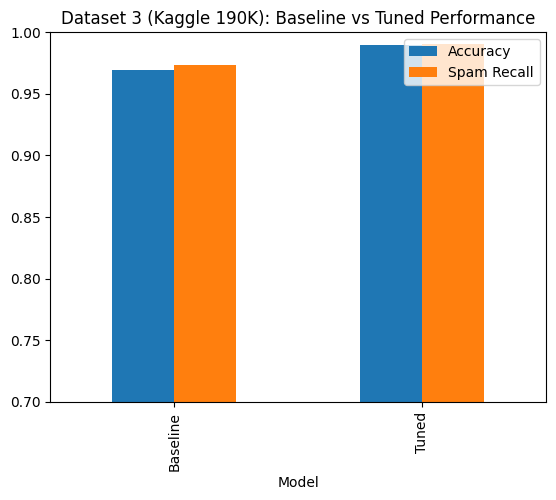

In [10]:
results_df_3.plot(
    x="Model",
    y=["Accuracy", "Spam Recall"],
    kind="bar",
    ylim=(0.7, 1.0),
    title="Dataset 3 (Kaggle 190K): Baseline vs Tuned Performance"
)

## Dataset 3 Summary
Dataset 3 is a large-scale email dataset (190K+ messages) used to test scalability and generalization. The baseline TF-IDF + Logistic Regression model achieves strong performance on the full test set. Hyperparameter optimization is performed on a stratified subset to control runtime, and results are compared on the full test set to evaluate whether tuning improves performance at scale.